# Lab 3: K-Means and the EM Algorithm

In this lab we will look at two famous algorithms, K-Means and Expectation-Maximization. These are both used as unsupervised-learning aglorithms for clustering, where the goal is to find hidden patterns in unlabeled data. Since the true labels, nor the number of discrete classes is usually unknown, we refer to these as unsupervised learning methods. 






## Lab Overview
### I. K-means Clustering 
### II. Binary Gaussian Mixtures 
### III. EM Algorithm

### You are responsible for finishing the functions provided to you in cells:
- **Cells 14-16**: K-Means and your result
- **Cells 22-24**: EM and your result


Since this lab will require us to compute the pdf of the normal distribution, we will rely on scipy's well known packages. You will not need anything else from scipy, as the point of this lab is to test your ability to construct algorithms, rather than rely on pre-made packages to do all your work. 

You can simply use the lab environment we already have, and install the additional package by running the following cell. If you want a new environment, you can always rely on the lab3.yml file provided in this folder. 

Setup the needed plotting environment, and load in the dependencies. You will only need scipy.stats.norm and its method scipy.stats.norm.pdf(). This will be used in the second part of the lab dealing with EM.

In [2]:
import numpy as np 
import pickle
import os
from numpy.random import default_rng
from scipy.stats import norm

rng = default_rng(seed=12345)

import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib as mpl
# colors used 
ORANGE = '#FF9132'
TEAL = '#0598B0'
GREEN = '#008F00'
PURPLE = '#8A2BE2'
GRAY = '#969696'
RED = '#B00805'
FIG_WIDTH = 4
FIG_HEIGHT = 3


plt.rcParams.update({
    "text.usetex": False,
    "font.family": "DejaVu Sans",
    "font.serif": ["Palatino"],
    "font.size": 12,
    "axes.titlesize": 15,
    "axes.spines.right": False,
    "axes.spines.top": False,
    "lines.linewidth": 3
})

### I. K-Means

We have all seen K-Means in class, and it looks pretty simple right? Can it really work on real datasets where the features express complex quantities? Yes, but remember, K-means is not created to be a classification algorithm, but rather a clustering algorithm. That is why it is usually used in recommendation systems, and not prediction systems. 

For our task, I have extracted a small subset of data from spotify, choosing **3 artists**, and selecting **200 songs from each**. The dataset that we want to cluster consists of these **600** shuffled songs, with each song having 11 features. We will try to use these features, and the K-Means algorithm to cluster the 600 songs into **3 clusters**. 

Since the true labels are provided, we can then check how the unsupervised learning framework did i.e., are the created clusters representitive of the artists?

As always, the data has been pickled into a dictionary with three keys:

**keys** - the features of the dataset

**tracks** - the actual dataset, np.array of dimension 600x11

**artists** - the labels, np.array of dimension 600.

In [4]:
spotify = pickle.load(open(os.getcwd()+'/data/spotify.p','rb'))
artists = np.array(['Drake','The Beatles','BTS'])

print('These are the features of each data sample: \n\n',spotify['keys'])
print('\nThis is your dataset shape:\n\n',spotify['tracks'].shape)
print('\nThis is how your labels look:\n\n',spotify['artists'][0:10])


These are the features of each data sample: 

 ['popularity' 'duration_ms' 'danceability' 'energy' 'key' 'loudness'
 'speechiness' 'acousticness' 'liveness' 'valnce' 'tempo']

This is your dataset shape:

 (600, 11)

This is how your labels look:

 ['Drake' 'The Beatles' 'Drake' 'Drake' 'The Beatles' 'Drake' 'The Beatles'
 'The Beatles' 'The Beatles' 'BTS']


It would be nice to color our dataset so that each point corresponding to a certain artist will have a color associated with it. Remember, this is just for visualization, as we will not use these labels or colors in our actual algorithm.

In [5]:
colors = np.array([ORANGE,TEAL,GREEN])
cmap = []
for artist in spotify['artists']:
    cmap.append(colors[np.argwhere(artist == artists).item()])

Remember normalization? Well here it is quite important as K-means gives the same weight to each feature. Lets load our normalized data into a variable called **tracks**. 

The below function is not the most efficient, but this way you can see what is actually going on. Each column (features) is being normalized as we are subtracting the mean and dividing by the standard deviation.

In [6]:
def normalize(x):
    '''
    Normalizes the input data
    '''
    new_x = np.zeros_like(x)
    for col in range(x.shape[1]):
        new_x[:,col] = (x[:,col]-x[:,col].mean())/x[:,col].std()
    return new_x

tracks = normalize(spotify['tracks'])


What are our features again? Do you think any of these features are correlated with the artist? We can check this visually. 

In [7]:
for i in range(len(spotify['keys'])):
    print('%d: '%i,spotify['keys'][i])


0:  popularity
1:  duration_ms
2:  danceability
3:  energy
4:  key
5:  loudness
6:  speechiness
7:  acousticness
8:  liveness
9:  valnce
10:  tempo


Pick two different features from below by choosing their correspond number (index). The cell will then plot these features for you. It would be nice to visualize everything, but the data is high-dimensional. I chose two features that are clearly differentiating the artists, but there could be others.

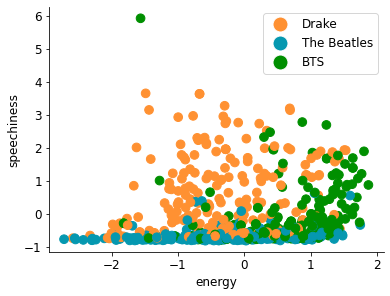

In [8]:
from matplotlib.lines import Line2D

# chose the axes for each feature
x_var = 3
y_var = 6

fig, axs = plt.subplots(1,1,figsize=(FIG_WIDTH*1.5,FIG_HEIGHT*1.5))
# we can now use the colormap we defined
axs.scatter(tracks[:,x_var],tracks[:,y_var],c=cmap,s=75)
legend_elements = [Line2D([0],[0],marker='o',color='w',label=artists[i],
                          markerfacecolor=colors[i], markersize=15) for i in range (len(artists))]
axs.legend(handles=legend_elements)
axs.set_xlabel(spotify['keys'][x_var])
axs.set_ylabel(spotify['keys'][y_var])
plt.show()

Okay so from the image we can see that Drake is clearly has less energy than the famous Korean Boy Band, and he does have a lot more to say than The Beatles. From here we can already see the clusters, but how will K-Means do?

For this you will have to try and find out.



**K-Means**

Given a dataset $\mathcal{X}=\{x_1,x_2,\ldots,x_N\}$ of $d$-dimensional vectors $x$, we want to find $k$ centroids, $\mathcal{C}=\{c_1,c_2,\ldots,c_k\}$, that minimze the distorion,$\mathcal{D}$ of our data. Where:

$$\mathcal{D}=\sum_{i=1}^{N}\big(x_i-c_{x_i}\big)^2$$

Above I denote $c_{x_i}$ as the centroid corresponding to data sample $x_i$.

I will skip the mathematical notation as the algorithm is quite simply stated in words. There are essentially three steps.

1) Initialize the Centroids Randomly


REPEAT (2-3):

2) For each point, find which centroid it is closest to and make it part of its cluster. 

3) Find the new cluster centers by taking the mean of the sets associated with each. 

A good measure for convergence in K-Means is distrotrion, which is basically the variance of each cluster. K-Means tries to minimize the distortion, which is the sum of squared distances from the data-points and their corresponding centers. It would be wise to somehow use this measure in your algorithm...

In [13]:
def Centroid_init(X, K):
    """
    Given training data X, this function initializes K different centroids
    Inputs:
        X - Data as np.array of dim: Nx(# features)
        K - Number of centroids
    
    Outputs:
        m - np.array of cluster centers, dimL Kx(# features)
    """
     
    m = rng.random([K,X.shape[1]])
    
    return m

In [14]:
m = Centroid_init(tracks,len(artists))
print(m)

[[0.72478136 0.86055132 0.9293378  0.54618601 0.93767296 0.49498794
  0.27377318 0.45177871 0.66503892 0.33089093 0.90345401]
 [0.25707418 0.33982834 0.2588534  0.35544648 0.00502233 0.62860454
  0.28238271 0.06808769 0.61682898 0.17632632 0.30438839]
 [0.44088681 0.15020234 0.21792886 0.47433312 0.47636886 0.25523235
  0.29756527 0.27906712 0.26057921 0.48276159 0.21197904]]


In [34]:
def Set(X, m):
    '''
    Now we define a function that creates the sets of data points closest
    to each centroid. Also it is useful to compute the distortion.
    Inputs:
        X - Data as np.array of dim: Nx(# features)
        m - np.array of cluster centers, dimL Kx(# features)
    
    Outputs:
        C - The sets for each cluster. There should be K sets inside C, 
            but you can play around with how you define C. I suggest using a 
            dict and storing the actual datapoints such that when you call
            C['i'], you get an np.array() of dim: Mx(# features), where M can vary in size.
            This is useful as np.arrays can not have varying length rows...
            
        D - Distortion as defined. This can just be a floating point.
    '''
    #calculate distances
    distances = np.zeros([X.shape[0],m.shape[0]])
    for i in range(m.shape[0]):
        distances[i] = np.linalg.norm(m-tracks[i], axis=1)
    #compute mask and sort into C    
    distortions = np.amin(distances, axis = 1)
    assignments = np.where(distances == distortions)
    #calculate distortion per cluster, sum
    C = {}
    Distortion = 0
    return distances
    #return (C, Distortion)

In [35]:
Set(tracks, m)

<ipython-input-34-ce83e41db73f>:24: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  assignments = np.where(distances == distortions)


array([[4.75060098, 4.09725309, 4.07623541],
       [4.07657201, 3.8423573 , 3.44235066],
       [4.57256928, 3.83678374, 4.29670335],
       ...,
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ]])

In [31]:

print(np.linalg.norm((m-tracks[0])[1]))

np.linalg.norm(m-tracks[0], axis=1)

4.0972530870907695


array([4.75060098, 4.09725309, 4.07623541])

In [11]:
C, D = Set(tracks,m)
for key in C:
    print('centroid %d: '%key, C[key].shape)
print('\nTotal Distortion: %.3f'%D)


Total Distortion: 0.000


In [12]:
def Update(X, C, m):
    '''
    This is step 3), where we update our cluster centers.
    If you followed the structure from before this step should 
    be very simple as C['i'] will store the entire set of datapoints
    associated with cluster i.

    Inputs:
        X - Data as np.array of dim: Nx(# features)
        C - Dictionary of sets corresponding to ea cluster
        m - np.array of cluster centers, dimL Kx(# features)
    
    Outputs:
        m - np.array of NEW cluster centers, dimL Kx(# features)
    
    HINT: Cluster centers can be empty if initialized poorly, so be careful
    '''
    try: 
        m = np.zeros((m.shape[0],X.shape[1]))
    except:
        m = np.zeros(m.shape[0])
    return m


In [13]:
m = Update(tracks,C,m)
print(m)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


You can use the backbone provided above if you want to, but the most important part is the function below. Make sure your output format is the same as I defined so that you can use the table printing function I have following this. If not feel free to edit it so it can easily display the result. 

In [14]:
def K_Means(X, K):
    '''
    Now put it all together. 

    Inputs:
        X - Data as np.array of dim: Nx(# features)
        K - Number of centroids
    
    Outputs
        m - np.array of FINAL cluster centers, dimL Kx(# features)
        D - The final distortion
    '''
    try: 
        m = np.zeros((K,X.shape[1]))
    except:
        m = np.zeros(K)
    D = 0
    print("DONE")
    return(m, D)

Run your algorithm in the cell below and store the centroids for the next part.

In [15]:
m, D = K_Means(tracks, len(artists))


DONE


Now lets check how you did.
 
What I do below is construct a table that records on each row i, how many songs  from each artist (columns) went to centroid i. You should see the majority of one artists songs going to a distinct cluster. If that is the case for all the artists, then K-Means worked pretty well. 

For the cell to work all you will need to have the variable **m** in the format I asked for.

In [16]:
# This will arbitrarily place all the aritst in the zeroth centroid until you have actual data. (since I initualized the count as zero)

artist_count = np.zeros((len(artists),len(artists)))
for idx in range(tracks.shape[0]):
    distance = np.linalg.norm((tracks[idx]-m),axis=1)**2
    centroid = np.argmin(distance)
    artist = spotify['artists'][idx]
    artist_count[centroid][np.argwhere(artist == artists).item()] += 1

print('\t',end="")
for art in artists:
    print(art[0:6]+'\t',end="")
print('\n')
for i in range(artist_count.shape[0]):
    print('K = %d \t'%i,end="")
    for j in range(artist_count.shape[1]):
        print(str(int(artist_count[i,j]))+'\t',end="")
    print("\n")
    



	Drake	The Be	BTS	

K = 0 	200	200	200	

K = 1 	0	0	0	

K = 2 	0	0	0	



### Gaussian Mixture Models

Before writing our EM algorithm, lets play around with plotting Gaussian mixtures to get a better understanding of what they are. Below I load the data provided to you.

In [17]:
Data = pickle.load(open(os.getcwd()+'/data/GMM.p','rb'))
Data

{'mu': [1.3, -1.8],
 'sigma': [0.7, 1.5],
 'pi': 0.3,
 'X': array([ 0.09559269,  1.11857874,  0.78138074, ..., -1.6359137 ,
         0.78075122,  2.02804039])}

X is your unlabeled dataset, and this time you are not given the labels since all the information about the data comes from the parameters. What are the parameters? The prior, the standard deviations, and the means. Your job is to use the EM algorithm to find these values. You can use the true values to test how well your algorithm is doing.

In [18]:
def plot_gmm(X,pi,mu,sigma,sol=None):
    '''
    Plots a GMM that is 1-dimensional and has 2-components.
    Uses scipy.stas to overlay the predicted gaussians

    Inputs: 
        X     - input data as 1-d np.array
        pi    - prior of componenet 1 (not 0)
        mu    - np array of means 
        sigma - np.array of stds
    '''
    # range of values
    MIN, MAX = X.min(), X.max()
    domain = np.linspace(MIN, MAX,100)

    fig, axs = plt.subplots(1,1)
    axs.set_xlim(MIN, MAX)
    # plot our values as a distribution
    axs.hist(X,bins=100,density=True,color='gray',alpha=0.3)
    # now plot the predicted gaussians over the same range
    g0 = (1-pi)*norm.pdf(domain,mu[0],scale=sigma[0])
    g1 = (pi)*norm.pdf(domain,loc=mu[1],scale=sigma[1])

    axs.plot(domain,g0,color=ORANGE,label='$g_0$',linestyle='--')
    axs.plot(domain,g1,color=TEAL,label='$g_1$',linestyle='--')
    plt.vlines(x=mu[0],ymin=0,ymax=g0[int(100*abs(MIN-mu[0])/abs(MAX-MIN))],color=ORANGE,label='$\mu_0$',alpha=0.5,linewidth=5)
    plt.vlines(x=mu[1],ymin=0,ymax=g1[int(100*abs(MIN-mu[1])/abs(MAX-MIN))],color=TEAL,label='$\mu_1$',alpha=0.5,linewidth=5)

    if sol is not None:
        plt.vlines(x=sol[0],ymin=0,ymax=g0[int(100*abs(MIN-sol[0])/abs(MAX-MIN))],color=ORANGE,label='$\hat{\mu}_0$',linewidth=2)
        plt.vlines(x=sol[1],ymin=0,ymax=g1[int(100*abs(MIN-sol[1])/abs(MAX-MIN))],color=TEAL,label='$\hat{\mu}_1$',linewidth=2)

    axs.legend()
    plt.xlabel('$x$')
    plt.ylabel('$P(x)$')
    plt.title('Gaussian Mixture Model')


So what is a Gaussian Mixture Model? It is a random variable that is derived as a sum of two weighted gaussian distributions. In the binary, case you can think of this variable as $X$, where we draw i.i.d. samples of $X$ by using the following pdf:

$$
p(X=x) = (1-\pi)g_0(x) + \pi g_1(x),
$$

where $g_0(x)$ and $g_1(x)$ are the **pdfs** of the distributions $\mathcal{N(\mu_0,\sigma_0^2)}$ and $\mathcal{N(\mu_1,\sigma_1^2)}$ respecitevely. These pdfs are sometimes denoted to as $\phi_{\mu_0,\sigma_0^2}$, and $\phi_{\mu_1,\sigma_1^2}$, and they can be computed by using the exact equation of the pdf, or in our case we will just rely on scipy.stats.norm.

Lets visualize our data, and plot the corresponding pdfs of the gaussians over the plot. 

Take note of how I used:

```python
g0 = (1-pi)*norm.pdf(domain,mu[0],scale=sigma[0])
g1 = (pi)*norm.pdf(domain,loc=mu[1],scale=sigma[1])
```

to get the values of the pdf for all locations that I wanted. You will need to use this function in your code for EM.

See [scipy.stats](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html) for more info

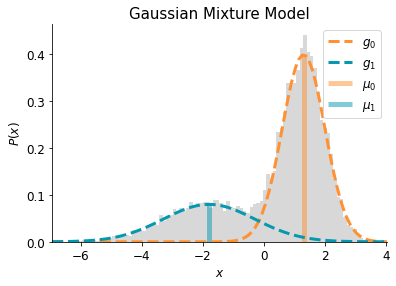

In [19]:
plot_gmm(Data['X'],Data['pi'],Data['mu'],Data['sigma'])



Okay so we already have K-Means written out, so might as well try to use it on this data. Note the extra variable in the plotting fucntion allows you to check your solution for the mean. Since K-Means only provides us with the mean, this is all we can do. On the other hand, EM will be able to solve for all the parameters we want: (mean, std, and prior)

DONE
[0. 0.]


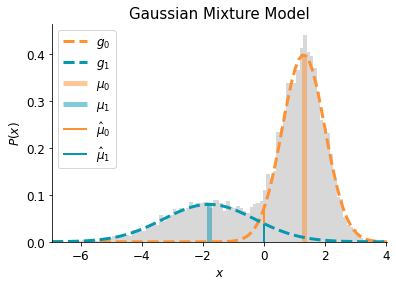

In [20]:
mu, D = K_Means(Data['X'],2)
print(mu)
# mu = mu.squeeze() # packs the data into one dimension
plot_gmm(Data['X'],Data['pi'],Data['mu'],Data['sigma'],sol=mu)

Not Bad, but also quite skewed. K-Means has no conseption of variance, and hence it skews the distribution means to the left when minimizing the distrortion. Since the data is actually represented by a gaussian mixture model, we should be able to get a much more accurate prediction using the EM algorithm.

### III. EM Algorithm

Okay so this time you will be more or less on your own, but the mathematical notation of the algorithm is provided to you. 

You are given a dataset $\mathcal{X}=\{x_1,x_2,\ldots,x_N\}$ of one-dimensinoal samples $x$ that come from a binary Guassian mixture model with the following true parameters:

$$\mu_0, \mu_1, \sigma_0, \sigma_1, \pi$$

We want to estimate these parameters, and hence we preform the EM algorithm  by doing the following steps:

1) Take initial guesses for the parameters (use K-Means): 
$$
\hat{\mu_0}, \hat{\mu_1}, \hat{\sigma_0}, \hat{\sigma_1}, \hat{\pi}
$$

2) **Expectation**-step:

compute the responsabilities, $\gamma_i$ for each sample $x_i$. These are essentially the probabilities that given the current parameters, **$x_i$ belongs to class 1**:

$$
\gamma_i = \frac{\hat{\pi}\phi_{\hat{\mu_1},\hat{\sigma_1}^2}(x_i)}{(1-\hat{\pi})\phi_{\hat{\mu_0},\hat{\sigma_0}^2}(x_i)+\hat{\pi}\phi_{\hat{\mu_1},\hat{\sigma_1}^2}(x_i)},\quad i=1,2,\ldots,N
$$

3) **Maximization**-step: 

compute the weighted means and variances using these responsabilities.

$$
\hat{\mu_0}=\frac{\sum_{i=1}^{N}\big((1-\gamma_i)x_i\big)}{\sum_{i=1}^{N}(1-\gamma_i)}, \quad \hat{\mu_1}=\frac{\sum_{i=1}^{N}\big(\gamma_i x_i\big)}{\sum_{i=1}^{N}\gamma_i}
$$

$$
\hat{\sigma_0^2}=\frac{\sum_{i=1}^{N}\big((1-\gamma_i)(x_i-\hat{\mu_0})^2\big)}{\sum_{i=1}^{N}(1-\gamma_i)}, \quad \hat{\sigma_1^2}=\frac{\sum_{i=1}^{N}\big(\gamma_i (x_i-\hat{\mu_1})^2\big)}{\sum_{i=1}^{N}\gamma_i}
$$

and rescale the prior

$$
\hat{\pi} = \frac{1}{N}\sum_{i=1}^{N}\gamma_i
$$
Reapeat the Expectation and Maximization Step until convergence.


Take note that you are updating the variance, not the standard deviation. 

In [21]:
def EM_step(X, pi, mu, sigma):
    '''
    Maybe you would like to isolate one step of the algorithm?
    '''
    return new_pi, new_mu, new_sigma

Ready to make your algorithm? Have all the helper functions you want created (or not)? Okay so same as before, follow the format of the output and you should be able to plot your solution using the table and function provided after this cell. 

In [22]:
def EM(X):
    '''
    The EM algorithm in it's least-full form. 

    Inputs:
        X - np.array of length N, since this is one dimensional data
    
    Outputs:
        pi    - just a floating point representing your FINAL prior
        mu    - 2-dimensional np.array, with your FINAL mu_0 and mu_1
        sigma - 2-dimensional np.array, with your FINAL sigma_0 and sigma_1
    '''
    pi = 0
    mu = np.zeros(2)
    sigma = np.zeros(2)
    return pi,mu,sigma

In [23]:
n_pi, n_mu, n_sigma= EM(Data['X'])
# results
print('\t\t True Values \t Predicted \t Error')
print('pi \t\t %.2f \t\t %.2f \t\t %.2f '%(Data['pi'],n_pi,abs(n_pi-Data['pi'])))
print('mu_0 \t\t %.2f \t\t %.2f \t\t %.2f'%(Data['mu'][0],n_mu[0],abs(n_mu[0]-Data['mu'][0])))
print('mu_1 \t\t %.2f \t\t %.2f \t\t %.2f'%(Data['mu'][1],n_mu[1],abs(n_mu[1]-Data['mu'][1])))
print('sigma_0 \t %.2f \t\t %.2f \t\t %.2f'%(Data['sigma'][0],n_sigma[0],abs(n_sigma[0]-Data['sigma'][0])))
print('sigma_1 \t %.2f \t\t %.2f \t\t %.2f\n'%(Data['sigma'][1],n_sigma[1],abs(n_sigma[1]-Data['sigma'][1])))


		 True Values 	 Predicted 	 Error
pi 		 0.30 		 0.00 		 0.30 
mu_0 		 1.30 		 0.00 		 1.30
mu_1 		 -1.80 		 0.00 		 1.80
sigma_0 	 0.70 		 0.00 		 0.70
sigma_1 	 1.50 		 0.00 		 1.50



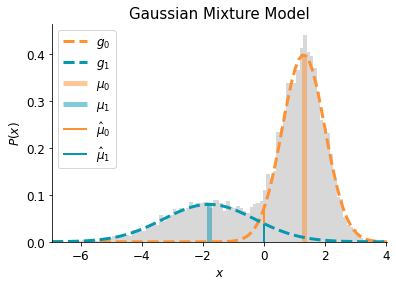

In [24]:
plot_gmm(Data['X'],Data['pi'],Data['mu'],Data['sigma'],sol=n_mu)